# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

to do list

- principle component analysis
- use different data umputing method for the data 
- what is the difference between pd.get_dummies and sklearn 
- data-refraction to amk

In [76]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling 
# magic word for producing visualizations in notebook
# %matplotlib inline

In [77]:
def drop_columns(df, threshold = 0.5):
    """Drop columns where the ratio of nan's surpass threshold
    
    Input:
    
    
    Return:
    """
    columns = df.columns
    filtered_col = df.isnull().mean() > threshold 
    columns_to_drop = columns[filtered_col] 
    df = df.drop(columns= columns_to_drop)
    
    return df

In [78]:
def drop_rows(df, threshold = 0.5):
    """Drop rows where the ratio of nan's surpass threshold"""
    
    rows = df.index.values[df.isna().mean(axis = 1)> threshold]
    df = df.drop(rows)
    
    return df

In [79]:
def hist_nan(df, axis = 0):
    """histogram for the percentage of missing values
    """
    
    plt.hist(df.isna().mean(axis = axis))
    ax = plt.gca()
    ax.set_xlabel('% of missing values');
    
    if axis ==0:
        ax.set_ylabel('column count');
    else:
        ax.set_ylabel('row count');
    
    return ax 

In [80]:
def feature_description(col):
    feature_mapping = pd.read_excel(
        'DIAS Attributes - Values 2017.xlsx', header=[1], usecols=[1, 2, 3, 4], index_col=[0, 1])
    
    return feature_mapping[col]

In [81]:
# pandas_profili

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [82]:
# load in the data

In [83]:
# customers = pd.read_csv(
#     './data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
# azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv',
#                      sep=';', low_memory=False)

In [84]:
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv',
                     sep=';', low_memory=False, nrows = 5000, )

del azdias['LNR']

In [85]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [86]:
len(azdias.columns)

365

## feature summary

I will first load the 'DIAS Attributes - Values 2017.xlsx' to understand how the missing or unkonwn values are handled in the data set. 


- Assign missing or unknown codes
    - The values for 'unknown', 'unknown / no main age detectable', 'no transactions known' or 'no transaction known' where used to define these codes.
    
- identify the data types
    - if contain numeric treated as numeric
    - else: treat the data as categorical 
    - identify if there is any non-numeric values in data, or else it needs to be transformed

### missing_or_unknown value encoding

In [87]:
df_features = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=[1], usecols=[1, 3, 4], index_col=[0, 1])

df_features = df_features.reset_index()

In [88]:
search_for = '|'.join(['no transactions', 'unknown'])
nan_idx = df_features['Meaning'].str.contains(search_for, na=False)

# values assigned to each attributes when missing or unknow
df_features_nan = df_features[nan_idx].copy().reset_index(drop=True)

In [89]:
def split_value(x):
    """For attributes that multiple values can represent the missing/unknown, split the value and return a list

    e.g. in 'ALTERSKATEGORIE_GROB' the unknown is recored using ('-1','0'). 
    by applying this function, the value is transformed to be [-1,0]
    """
    try:
        return [int(a) for a in x.split(',')]
    except:
        return [x]

In [90]:
df_features_nan['Value'] = df_features_nan['Value'].apply(split_value)

In [91]:
df_features_nan.to_csv('feature_nan.csv')

#### identify data type 

- numeric column contains 'numeric'
- other columns to be treated as categorical

In [92]:
to_drop = []

In [93]:
num_cols_idx = df_features['Meaning'].str.contains('numeric', na = False)
num_cols = df_features.loc[num_cols_idx, 'Attribute'].unique()
cat_cols = df_features.loc[~num_cols_idx, 'Attribute'].unique()

In [94]:
ord_cols_idx = df_features['Meaning'].str.contains('very high', na = False)
ord_cols = df_features.loc[ord_cols_idx, 'Attribute'].unique()

In [164]:
# for col in azdias.select_dtypes('object').columns:
#     print('='*50)
#     print(col)
#     print('-'*50)
#     print(azdias[col].unique())
#     print('='*50)

In [165]:
azdias.select_dtypes('object').columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')

In [166]:
# these two columns not included in feature meta data file
# LETZTER_KAUF_BRANCHE: last purchase sector
# EINGEFUEGT_AM: INSERTED ON
# These two columns are not too relavent

to_drop.extend(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'])
to_label_encoder = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ']

in column ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] there are unknown values encoded as 'X' or 'XX'. it is therefore necessary to replace them with np.nan

### replace the values in with np.nan

<AxesSubplot:xlabel='% of missing values', ylabel='column count'>

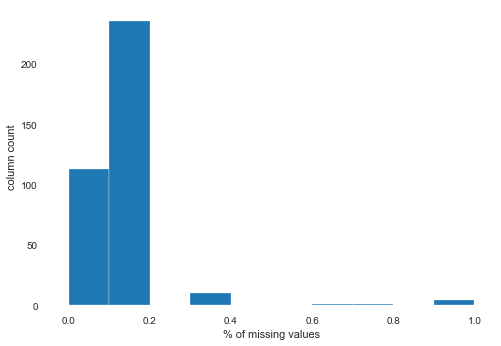

In [99]:
# hist before updating the dataframe
hist_nan(azdias, axis=0)

In [100]:
# compare the columns in the attributes table and the azdias table

In [101]:
for idx, row in df_features_nan.iterrows():
    try:
        azdias[row.Attribute].replace(row.Value, np.nan, inplace = True)
    except:
        print("{:} is not contained in the data".format(row.Attribute))

BIP_FLAG is not contained in the data
CAMEO_DEUINTL_2015 is not contained in the data
D19_KK_KUNDENTYP is not contained in the data
GEOSCORE_KLS7 is not contained in the data
HAUSHALTSSTRUKTUR is not contained in the data
KBA13_CCM_1400_2500 is not contained in the data
SOHO_FLAG is not contained in the data
WACHSTUMSGEBIET_NB is not contained in the data


In [102]:
# Sanity check
azdias['WOHNDAUER_2008'].unique()

array([nan,  9.,  8.,  3.,  4.,  5.,  6.,  2.,  7.,  1.])

<AxesSubplot:xlabel='% of missing values', ylabel='column count'>

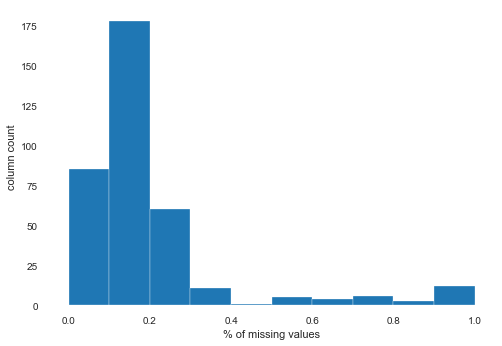

In [103]:
hist_nan(azdias, axis= 0 )

#### Drop attributes not inlcuded in summary table

we are not sure about how those data were encoded, as it doesn't provide much information. as a first attemp, i will discard those information 

In [104]:
to_drop = list(set(azdias.columns) - set(df_features.Attribute))
print(to_drop) 

['DSL_FLAG', 'D19_VERSI_OFFLINE_DATUM', 'D19_BANKEN_REST', 'D19_TELKO_MOBILE', 'CJT_TYP_3', 'D19_KOSMETIK', 'CJT_TYP_1', 'D19_HANDWERK', 'RT_SCHNAEPPCHEN', 'KBA13_ANTG4', 'EINGEFUEGT_AM', 'KBA13_ANTG2', 'D19_BUCH_CD', 'CJT_TYP_5', 'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_DATUM', 'KBA13_BAUMAX', 'VK_DHT4A', 'CJT_TYP_6', 'KBA13_GBZ', 'VK_DISTANZ', 'ARBEIT', 'D19_VERSI_ONLINE_DATUM', 'KBA13_ANTG3', 'VK_ZG11', 'EXTSEL992', 'ALTER_KIND4', 'D19_SAMMELARTIKEL', 'KBA13_CCM_1401_2500', 'D19_NAHRUNGSERGAENZUNG', 'CJT_KATALOGNUTZER', 'D19_VERSI_ONLINE_QUOTE_12', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND1', 'D19_SONSTIGE', 'KBA13_HHZ', 'D19_VERSAND_REST', 'AKT_DAT_KL', 'D19_VERSICHERUNGEN', 'D19_HAUS_DEKO', 'D19_LOTTO', 'ALTER_KIND3', 'MOBI_RASTER', 'ALTERSKATEGORIE_FEIN', 'KONSUMZELLE', 'CJT_TYP_2', 'VHA', 'D19_SCHUHE', 'D19_RATGEBER', 'VHN', 'D19_BANKEN_GROSS', 'UMFELD_JUNG', 'D19_ENERGIE', 'D19_VOLLSORTIMENT', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'D19_BILDUNG', 'D19_BANKEN_LOKAL', 'D19_TECHNIK', 'D19_LEBE

In [105]:
azdias = azdias.drop(columns=to_drop)

In [106]:
# Sanity check if it still contains strings
for col in azdias.columns:
    if any(isinstance(y,(str)) for y in azdias[col].unique()):  
        print('{:}, {:}'.format( col , azdias[col].unique()))

CAMEO_DEU_2015, [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015, [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
OST_WEST_KZ, [nan 'W' 'O']


In [107]:
azdias.replace(['X','XX'], np.nan, inplace=True);

In [108]:
for col in azdias.columns:
    if any(isinstance(y,(str)) for y in azdias[col].unique()):  
        print('{:}, {:}'.format( col , azdias[col].unique()))

CAMEO_DEU_2015, [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015, [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
OST_WEST_KZ, [nan 'W' 'O']


In [109]:
to_lable_encoder = []

#### To - do 

- Further data cleaning is required for columns above 
    - CAMEO_DEU_2015: replace XX with np.nan, the rest are categorical, not sure how to deal with it yet. 
    - CAMEO_DEUG_2015: replace X with np.nan
    - OST_WEST_KZ: catgorical
        - label-encoder


#### Drop rows and columns where the portion of nan's exceedes the threshold

In [110]:
# In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 
# Select at least five of these columns and compare the distribution of values.

In [111]:
# split into two dataframes based on ratio of nan's 

In [112]:
def compare_hist(df1, df2, col, density = False):

    fig, ax = plt.subplots(2, sharex=True)

    ax[0].hist(df1[col].dropna(), color='lightblue', alpha=0.5,
               density=density, bins=len(df1[col].unique()))
    ax[1].hist(df2[col].dropna(), color='salmon', alpha=0.5,
               density=density, bins=len(df1[col].unique()))

    ax[0].title.set_text('Distribution AFTER removing the rows')
    ax[1].title.set_text('Distribution BEFORE removing the rows')

    ax[1].set_xlabel(col)
    ax[0].set_ylabel('percentage')
    ax[1].set_ylabel('percentage')

In [113]:
threshold = 0.3
idx_to_drop = azdias.isna().mean(axis = 1) > threshold
_df = azdias.loc[~idx_to_drop]
# df_2 = azdias.loc[idx_to_drop]

In [114]:
# Select five attributes from the list, and compare the distribution of two dfs

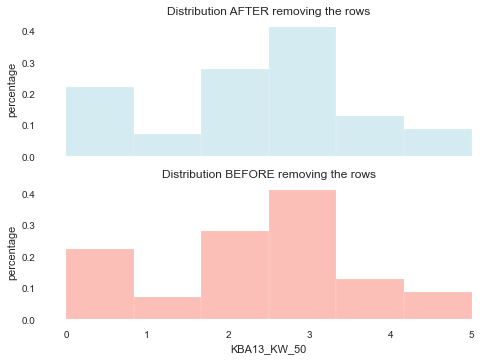

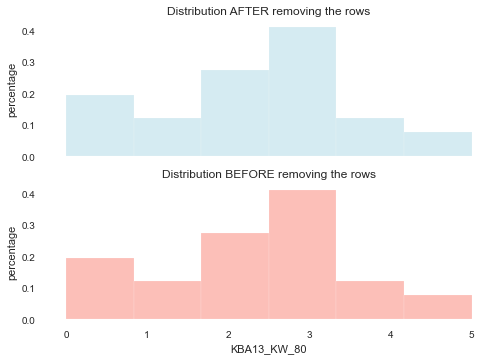

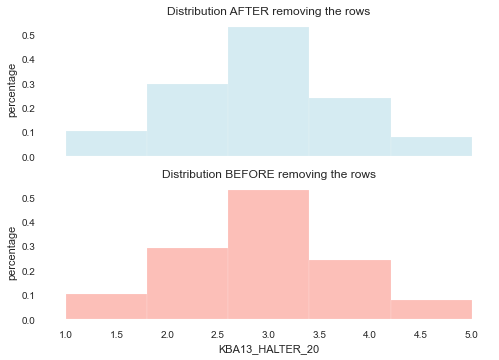

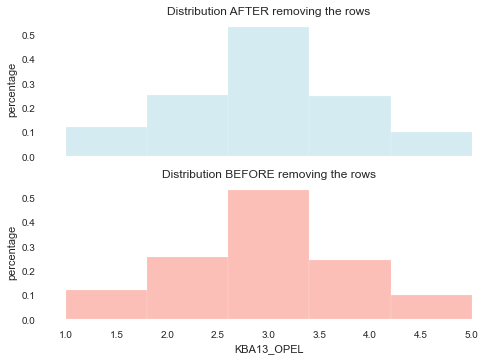

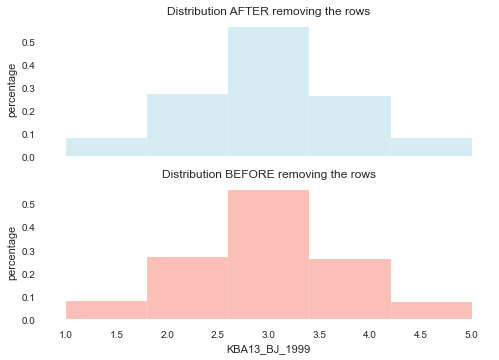

In [115]:
test_cols = np.random.choice(azdias.columns, 5)

for test_col in test_cols: 
    compare_hist(_df, azdias, test_col, density=True)

In [116]:
# fig, ax = plt.subplots(2, sharex=True)

# sns.countplot(x= test_cols[0], data=_df, ax= ax[0])
# sns.countplot(x= test_cols[0], data=azdias, ax= ax[1])

# ax[0].title.set_text('Distribution AFTER removing the rows')
# ax[1].title.set_text('Distribution BEFORE removing the rows')

distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. 

In [117]:
azdias = drop_columns(azdias, threshold = 0.3)
azdias = drop_rows(azdias, threshold = 0.3)

#### Imputing, replace the nan's with either the mean median or mode

In [118]:
# Use the correlation matrix to remove the highly correlated columns

corr_matrix = azdias.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# print(to_drop)
print("We will drop {:} columns, since they are highly correlated to other data in the dataframe".format(
    len(to_drop)))

# To do: perform a sanity check

We will drop 59 columns, since they are highly correlated to other data in the dataframe


In [119]:
azdias.drop(columns=to_drop, inplace=True)

In [120]:
## Summary of nans for  each column
# NaN count in columns where
azdias_nan  = azdias.isna().mean() * 100 #portion of NaN
azdias_nan_ = azdias_nan.loc[azdias_nan>0]

<AxesSubplot:>

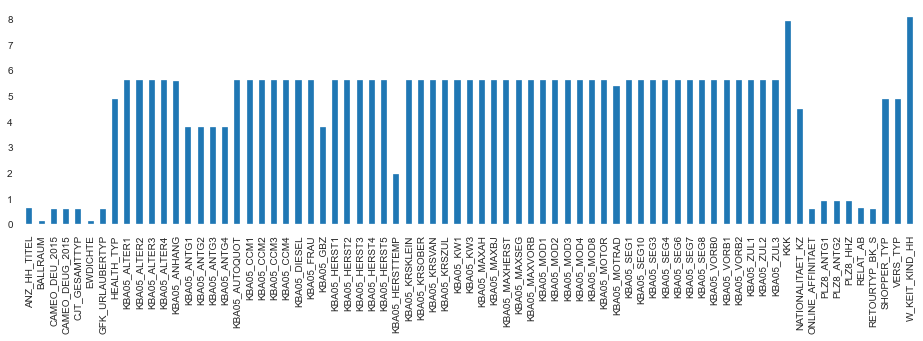

In [121]:
azdias_nan_.plot(kind = 'bar', figsize = (16,4))

#### how to deal with nan's?

#### Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features needs to be scaled 
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes). -> to be scaled
- Special handling may be necessary for the remaining two variable types: categorical
- Mixed data is also treated the same way as cat-data



to do: 
- identify the categorical data, and mixed values

In [122]:
for col in num_cols:
    print('='*50)
    print(col)
    print('-'*50)
    print(azdias[col].unique())

ANZ_HAUSHALTE_AKTIV
--------------------------------------------------
[ 11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.   7.
  44.  25.  36. 272.  33.  15.  12.  22.  21.  20.  23.  18.  27.  24.
  31.  39.  16.  19.  30.  17.  29.  61.  54.  88.  49.  60.  38.  34.
  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.  43.  52.  41.
  76.  63.  32.  40.  37.  59.  53.  57. 118.  95.  78.  70.  46.  73.
  67. 154.  80. 102.  92. 126.  48.  94.  71.  66.  68.  81.  69. 121.
 258.]
ANZ_HH_TITEL
--------------------------------------------------
[ 0.  1.  5. nan  2.  3.  7.  4.  6.]
ANZ_PERSONEN
--------------------------------------------------
[ 2.  1.  0.  4.  3.  5.  6.  7.  8. 12.  9.]
ANZ_TITEL
--------------------------------------------------
[0. 1. 2.]
GEBURTSJAHR
--------------------------------------------------
[1996 1979 1957 1963 1943    0 1964 1974 1975 1941 1993 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965
 1978 1

In [123]:
# Replace o in GEBURTSJAHR as np.nan
azdias['GEBURTSJAHR'].replace(0, np.nan, inplace=True)
# Sanity check
azdias['GEBURTSJAHR'].unique()

array([1996., 1979., 1957., 1963., 1943.,   nan, 1964., 1974., 1975.,
       1941., 1993., 1988., 1991., 1966., 1949., 1982., 1972., 1990.,
       1985., 1989., 1948., 1935., 1997., 1994., 1987., 2002., 1950.,
       1965., 1978., 1958., 1944., 1967., 1977., 1960., 1970., 1973.,
       1971., 1937., 1947., 1926., 1954., 1946., 1981., 1962., 1992.,
       2008., 1976., 1928., 1927., 1968., 1940., 1952., 1961., 2006.,
       1938., 1945., 1942., 1984., 1930., 1980., 1959., 1986., 1931.,
       1955., 1983., 2010., 1951., 1921., 1929., 1939., 2001., 1995.,
       1956., 1953., 1969., 2012., 1934., 1913., 1914., 1922., 2004.,
       1936., 2009., 2003., 2013., 1998., 2007., 1932., 2005., 1923.,
       1925., 1933., 2017., 2000., 1999., 2014., 1920.])

<AxesSubplot:xlabel='% of missing values', ylabel='column count'>

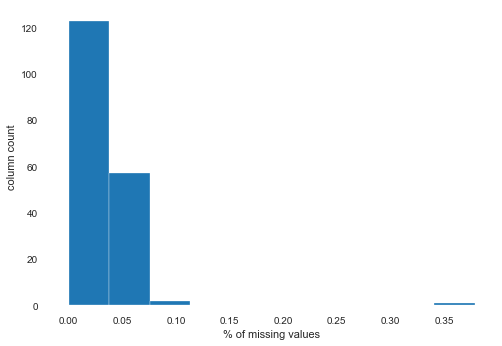

In [124]:
hist_nan(azdias)

#### Imputing missing value

In [125]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [126]:
# Replace NaN using the most frequent item in each column
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

azdias_transformed = pd.DataFrame(imp.fit_transform(azdias))
azdias_transformed.columns= azdias.columns
azdias_transformed.index=azdias.index

In [127]:
num_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [162]:
cat_cols = list(set(azdias.columns) - set(ord_cols) - set(num_cols))

In [129]:
for col in azdias.columns:
    if any(isinstance(y,(str)) for y in azdias[col].unique()):  
        print('{:}, {:}'.format( col , azdias[col].unique()))

CAMEO_DEU_2015, ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015, ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
OST_WEST_KZ, ['W' 'O']


In [167]:
# to_label_encoder = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ']

In [131]:
le = preprocessing.LabelEncoder()

for col in to_label_encoder:
    try:
        azdias_transformed[col] = le.fit_transform(azdias_transformed[col])
    except:
        print('{:} not in dataframe anymore'.format(col))

In [156]:
azdias_transformed = pd.get_dummies(azdias_transformed, drop_first= True, columns = cat_cols.extend(to_label_encoder))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [62]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')